In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import itertools
import os
import string
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, LSTM, Dropout, Input
from keras.callbacks import Callback

In [72]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**HyperParameter**

In [ ]:
MAXLEN = 32
MINLEN = 3
NGRAM = 5
INVERT = True #bidirectional 
BATCH_SIZE = 128
VALIDATION_SIZE = 200000
HIDDEN_SIZE = 256

**Preprocessing Data**

In [ ]:
data_path = "/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/train_tieng_viet.txt"

with open(data_path) as f:
    train = f.readlines()

In [ ]:
sentences = []
for i in range(len(train)):
    [idx, sen] = train[i].split('\t')
    sen = sen[:-1]
    sentences.append(sen)

In [ ]:
def normalizeString(s):
    # Tách dấu câu nếu kí tự liền nhau
    marks = '[.!?,-${}()]'
    r = "(["+"\\".join(marks)+"])"
    s = re.sub(r, r" \1 ", s)
    # Thay thế nhiều spaces bằng 1 space.
    s = re.sub(r"\s+", r" ", s).strip()
    return s
sentences = [normalizeString(sen).lower() for sen in sentences[:200000]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Possible nested set at position 2
  """


In [73]:
len(sentences)

200000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f751eb75290>]],
      dtype=object)

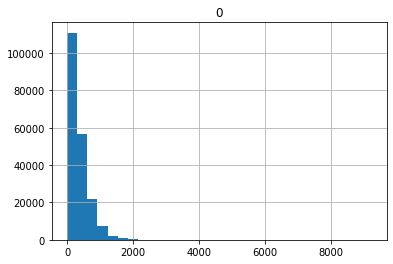

In [ ]:
pd.DataFrame([len(t) for t in sentences]).hist(bins=30)

**Generate N-grams**

In [ ]:
def gen_ngrams(words, n=3):
    """ gen n-grams from given phrase or list of words """
    if isinstance(words, str):
        words = re.split('\s+', words.strip())
    
    if len(words) < n:
        padded_words = words + ['\x00'] * (n - len(words))
        yield tuple(padded_words)
    else:
        for i in range(len(words) - n + 1):
            yield tuple(words[i: i+n])

In [ ]:
ngrams = itertools.chain.from_iterable(gen_ngrams(p, NGRAM) for p in sentences)
ngrams = list(set(' '.join(t) for t in set(ngrams)))
[print(t) for t in ngrams[:5]]
print('Number of {}-gram: {}'.format(NGRAM, len(ngrams)))

, 95% là các hiđrô
xã minh tâm và ấp
hùng khác nhau của dc
tát ra các vị cai
chức vụ: phó phòng; cục
Number of 5-gram: 13461774


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74fc193a90>]],
      dtype=object)

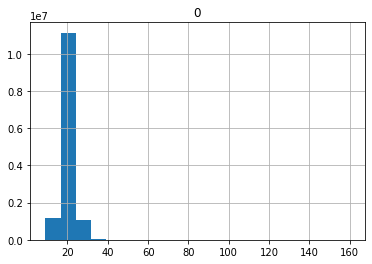

In [ ]:
pd.DataFrame([len(ngram) for ngram in ngrams]).hist(bins=20)

In [74]:
print(np.random.rand())

0.6448454261785125


**Helper Function**

In [ ]:
accented_chars = {
    'a': u'a á à ả ã ạ â ấ ầ ẩ ẫ ậ ă ắ ằ ẳ ẵ ặ',
    'o': u'o ó ò ỏ õ ọ ô ố ồ ổ ỗ ộ ơ ớ ờ ở ỡ ợ',
    'e': u'e é è ẻ ẽ ẹ ê ế ề ể ễ ệ',
    'u': u'u ú ù ủ ũ ụ ư ứ ừ ử ữ ự',
    'i': u'i í ì ỉ ĩ ị',
    'y': u'y ý ỳ ỷ ỹ ỵ',
    'd': u'd đ',
}

plain_char_map = {}
for c, variants in accented_chars.items():
    for v in variants.split(' '):
        plain_char_map[v] = c


def remove_accent(text):
    sen = []
    for char in text:
       if char in plain_char_map.keys():
          if np.random.rand() > 0.75:
             sen.append(plain_char_map[char])
          else:
             sen.append(char)
       else:
         sen.append(char) 
    return ''.join(sen)

In [102]:
class CharacterCodec(object):
    def __init__(self, alphabet, maxlen):
        self.alphabet = list(sorted(set(alphabet)))
        self.index_alphabet = dict((c, i) for i, c in enumerate(self.alphabet))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.alphabet)))
        for i, c in enumerate(C[:maxlen]):
            if c not in self.alphabet:
               X[i,self.index_alphabet['\x00']] = 1
            else:
               X[i, self.index_alphabet[c]] = 1
        return X
    
    def try_encode(self, C, maxlen=None):
        try:
            return self.encode(C, maxlen)
        except KeyError:
            return None

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.alphabet[x] for x in X)


#\x00 is the padding characters
alphabet = set('\x00 _' + string.ascii_lowercase + string.digits + ''.join(plain_char_map.keys()))
codec = CharacterCodec(alphabet, MAXLEN)

**Generate data**

In [103]:
np.random.shuffle(ngrams)
train_size = len(ngrams) - VALIDATION_SIZE
train_set = ngrams[:train_size]
validation_set = ngrams[train_size:]

def gen_batch(it, size):
    """ batch the input iterator to iterator of list of given size"""
    for _, group in itertools.groupby(enumerate(it), lambda x: x[0] // size):
        yield list(zip(*group))[1]


def gen_stream(ngrams):
    """ generate an infinite stream of (input, output) pair from phrases """
    while True:
        for s in ngrams:
            output_s = s + '\x00' * (MAXLEN - len(s))
            input_s = remove_accent(output_s)    
            input_s = input_s[::-1] if INVERT else input_s
            input_vec = codec.try_encode(input_s)
            output_vec = codec.try_encode(output_s)
            if input_vec is not None and output_vec is not None:
                yield input_vec, output_vec


def gen_data(ngrams, batch_size=128):
    """ generate infinite X, Y array of batch_size from given phrases """
    for batch in gen_batch(gen_stream(ngrams[500000:]), size=batch_size):
        # we need to return X, Y array from one batch, which is a list of (x, y) pair
        X, Y = zip(*batch)
        yield np.array(X), np.array(Y)

**Training**

In [ ]:
model_LSTM = Sequential([
    LSTM(HIDDEN_SIZE,input_shape = (MAXLEN,len(alphabet))),
    RepeatVector(MAXLEN),
    LSTM(HIDDEN_SIZE, return_sequences=True),
    LSTM(HIDDEN_SIZE, return_sequences=True),
    TimeDistributed(Dense(len(alphabet))),
    Activation('softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=50,
                                                      mode='min',
                                                      restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM', monitor='val_loss', save_best_only=True, save_feq='epoch')
model_LSTM.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [100]:
print(alp)

{'ề', 'ô', 'ế', 'x', 'h', 'ể', 'ú', 'ạ', 'ỡ', 'ẹ', 't', 'ẫ', '2', 'ẳ', 'ù', 'ẵ', 'â', 'ă', 'b', 'ĩ', 'ứ', 'ợ', ' ', 'ở', 'e', 'ý', '4', 'ớ', 'f', 'c', 's', 'ầ', 'm', 'ừ', 'p', 'ê', 'ộ', 'ậ', '0', 'ờ', 'đ', 'k', 'ồ', 'v', 'a', 'ỷ', '3', 'ụ', 'ả', 'g', 'ằ', 'í', 'ư', 'á', 'ỵ', 'd', 'l', 'ì', 'q', 'ẩ', 'ẽ', 'ự', 'ỗ', 'ơ', 'ã', '9', 'ọ', '6', 'é', 'ỉ', 'u', '1', '5', 'ò', 'i', 'ỹ', 'ắ', '_', 'o', 'ổ', 'w', 'ử', 'z', 'r', 'ủ', 'ố', 'ỳ', 'y', 'è', 'à', 'ó', '7', 'ỏ', 'ệ', 'ấ', 'ữ', 'õ', 'ũ', 'n', 'j', 'ẻ', '\x00', '8', 'ị', 'ễ', 'ặ'}


In [ ]:
model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 256)               371712    
                                                                 
 repeat_vector_3 (RepeatVect  (None, 32, 256)          0         
 or)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 32, 256)           525312    
                                                                 
 lstm_13 (LSTM)              (None, 32, 256)           525312    
                                                                 
 time_distributed_4 (TimeDis  (None, 32, 106)          27242     
 tributed)                                                       
                                                                 
 activation_4 (Activation)   (None, 32, 106)          

In [ ]:
train_generator = gen_data(train_set, batch_size=BATCH_SIZE)
validation_generator = gen_data(validation_set, batch_size=BATCH_SIZE)

history = model_LSTM.fit(train_generator,epochs=1200,steps_per_epoch=50,
                    validation_data=validation_generator,validation_steps=10,verbose=1)

In [ ]:
model_LSTM.save_weights('/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/weights2.h5', overwrite=True)
model_json = model_LSTM.to_json()
with open("/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/model2.json", "w") as json_file:
    json_file.write(model_json) 

In [117]:
test_set = train_set[-10000:]
test_generator = gen_data(test_set, batch_size=BATCH_SIZE)

In [119]:
import pickle

with open('/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/sentences.pkl', 'wb') as handle:
    pickle.dump(sentences[-10000:], handle)

In [125]:
with open('/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/sentences.pkl', 'rb') as handle:
    b = pickle.load(handle)

print(b)

viện cũng tư vấn , đào tạo và chuyển giao một số công nghệ khác .


In [ ]:
test_set

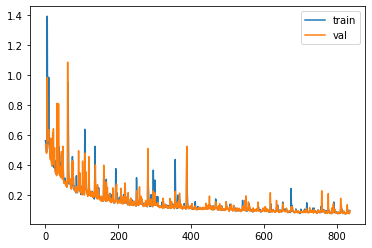

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

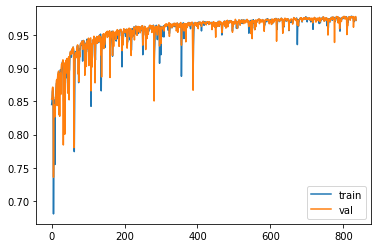

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

In [ ]:
model_LSTM = tf.keras.models.load_model('/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM')

In [ ]:
from collections import Counter


def guess(ngram):
    text = ' '.join(ngram)
    text += '\x00' * (MAXLEN - len(text))
    if INVERT:
        text = text[::-1]
    preds = model_LSTM.predict(np.array([codec.encode(text)]), verbose=0)
    classes_x = np.argmax(preds,axis=-1)
    
    return codec.decode(classes_x[0], calc_argmax=False).strip('\x00')


def add_accent(text):
    ngrams = list(gen_ngrams(text.lower(), n=NGRAM))
    guessed_ngrams = list(guess(ngram) for ngram in ngrams)
    
    candidates = [Counter() for _ in range(len(guessed_ngrams) + NGRAM - 1)]
    print(len(candidates))
    for nid, ngram in enumerate(guessed_ngrams):
        for wid, word in enumerate(re.split(' +', ngram)):
            if nid + wid >= len(candidates):
               break
            candidates[nid + wid].update([word])
    output = ' '.join(c.most_common(1)[0][0] for c in candidates)
    return output

print(u'"{}"'.format(add_accent('co khi nao roi xa')))

5
"e1   bbbaaa 4d     2 0  c 10  c  0c c01"
